In [607]:
import pandas as pd
import numpy as np

import random

import tensorflow
import keras

import nltk
import re
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
# for BERT
!pip install transformers
import transformers

from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Read the data in

In [608]:
df = pd.read_csv("gdrive/My Drive/twitter_data.csv", encoding='latin-1', header= None) # Read the data in

In [609]:
df.head(5)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


**target:** the polarity of the tweet (0 = negative, 4 = positive) 

**ids:** The id of the tweet ( 2087)

**date:** the date of the tweet (Sat May 16 23:58:44 UTC 2009)

**flag:** The query (lyx). If there is no query, then this value is NO_QUERY.

**user:** the user that tweeted (robotickilldozr)

**text:** the text of the tweet (Lyx is cool)

Pick out the relavant data

In [610]:
df = df.drop(columns= [1, 2, 3, 4])  # Drop all useless data
df.columns = ['emotion', 'tweet'] # Rename the relavant columns

Too much data is given here so lets cut down on the amount

In [611]:
len(df)  # there was 1.6 mill data here. Im using google collab here so it'll definitely crash the computer

1600000

I will decide upon having 60, 000 data for the train data and 20000 for test data. There are only 2 sentiments. To ensure its a fair process i'll take 30, 000 tweets from each category for train and 10,000 for test.



In [612]:
# create new df containing negative sentiment
df_negative = df[df['emotion'] == 0]

# create new df containing positive sentiment
df_positive = df[df['emotion'] == 4]

In [613]:
# This ensures we only get tweets that are less than 50 words long

df_negative = df_negative[df_negative['tweet'].apply(lambda x: len(x.split(" ")) <= 48)]

df_positive = df_positive[df_positive['tweet'].apply(lambda x: len(x.split(" ")) <= 48)]

In [614]:
from sklearn.utils import shuffle  # to mix things up a bi t and introduce some randomness
df_negative = shuffle(df_negative)

df_positive = shuffle(df_positive)

In [615]:
df_negative = df_negative[:40000]
df_positive = df_positive[:40000]

Shuffle one more time for good measure (shuffling introduces randomness)

In [616]:
df_negative = shuffle(df_negative)

df_positive = shuffle(df_positive)

Before we split them into test and train lets look at the data again

In [617]:
df_negative = df_negative.reset_index(drop=True)

df_positive = df_positive.reset_index(drop=True)

df_negative

,emotion,tweet
0,0,"just got back from the show, it was hilrious !..."
1,0,"Its June 6th 2009, my birthday. Its 2:14 A.M. ..."
2,0,leaving buena park but ill be back in a few w...
3,0,doesnt want keith to die ...might skip that e...
4,0,got burnt today
...,...,...
39995,0,I'm so tired and suddenly I think covering tha...
39996,0,Another friend knocked up. Pretty soon every...
39997,0,stuying commercial law ALL DAY
39998,0,@marano2288 hahaha. Because Toucan Sam has a b...


You can see that some tweets has 

**@username_blah1**

**hastag#Glazers_out**

**links like (http://, https://, www. ect..)**

These are unimportant and shoudnt bear importance in negative/positive (Or at least i'll take it as such)



**More data cleaning is thus required**

In [618]:
type(df_negative['tweet'][0]) # the data in tweet is of type string

str

In [619]:
# these regexesr enable us to filter out unwanted data
regex1 = re.compile('@') # format to remove @username_chungus from a string
regex2 = re.compile('#') # format to remove #Ole'sAtTheWheel from a string
regex3 = re.compile('http') # format to remove http/https://blahblah.com (Dont blame me if you click this link i dunno where it goes) from a string
regex4 = re.compile('www') # format to remove www.blahblah.com from a string
regex5 = re.compile('\d') # format to remove numbers from a string
regex6 = re.compile(r'[^\w\s]') # format to remove punctuations from a list

# I want to know what the max length of a tweet is
max_negative_tweet_length = -10
max_positive_tweet_length = -10

for i in range(len(df_negative)):
  process_negative = df_negative['tweet'][i]
  process_negative = process_negative.split(" ")
  
  process_negative = [s for s in process_negative if not regex1.match(s)]
  process_negative = [s for s in process_negative if not regex2.match(s)]
  process_negative = [s for s in process_negative if not regex3.match(s)]
  process_negative = [s for s in process_negative if not regex4.match(s)]
  process_negative = [s for s in process_negative if not regex5.match(s)]
  process_negative = [s for s in process_negative if not regex6.match(s)]

  if (len(process_negative) > max_negative_tweet_length):
    max_negative_tweet_length = len(process_negative)

  df_negative['tweet'][i] =  " ".join(process_negative)
  df_negative['tweet'][i] = re.sub(r'[^\w\s]', '', df_negative['tweet'][i]) # format to remove punctuations from a string

 # Now for the positive portion
  process_positive = df_positive['tweet'][i]
  process_positive = process_positive.split(" ")
  
  process_positive = [s for s in process_positive if not regex1.match(s)]
  process_positive = [s for s in process_positive if not regex2.match(s)]
  process_positive = [s for s in process_positive if not regex3.match(s)]
  process_positive = [s for s in process_positive if not regex4.match(s)]
  process_positive = [s for s in process_positive if not regex5.match(s)]
  process_positive = [s for s in process_positive if not regex6.match(s)]

  if (len(process_positive) > max_positive_tweet_length):
    max_positive_tweet_length = len(process_positive)
    
  df_positive['tweet'][i] =  " ".join(process_positive)
  df_positive['tweet'][i] = re.sub(r'[^\w\s]', '', df_positive['tweet'][i]) # format to remove punctuations from a string


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to b

In [620]:
print("Maximum length of a negative tweet is: ", max_negative_tweet_length)
print("Maximum length of a positive tweet is: ", max_positive_tweet_length)

Maximum length of a negative tweet is:  41
Maximum length of a positive tweet is:  34


The disparity is quite big so this does show that we should have indicated a maximum number of words in a tweet from the start. 

By the time you are reading this i would have already done so, so no worries :)

The concept behind this is to ensure that the vector space wouldnt be too sparse. Else we would require a lot (A lot) of padding, and this might cause the model to perform poorly. (Also i'likely run out of resources too).

A solution to this is to just pick a number to be the max length. For our case, 70 sounds good enough. However, this also means our model would be unable to classify tweets that are more than 70 words long. 

**Data cleaning should be done. We can now begin tokenizing.**

In [621]:
df_positive

,emotion,tweet
0,4,Carrie Fisher Im just on a big biography kick ...
1,4,Off to the grandparents house for dinner Peac...
2,4,just finished eating a slice of strawberry pie...
3,4,Yep its mine Went to the screening in Orlando...
4,4,Enjoying d view sg flyer
...,...,...
39995,4,Glad you like them x
39996,4,i truly felt blessed and feel free of all the ...
39997,4,Woahhhmarie just got jimmyjackeddd hahahahaa
39998,4,at least if you forget it theres always youtube


Looking good. The text has been cleaned. More or less. We can now proceed to perform **tokenizing** via the BERT provided one. It's some good stuff. We'll than need to do the **masking** and **padding** as required by BERT.

The BERT model accepts inputs using as a matrix of these three inputs (in bold)

In [622]:
## distil-bert tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

In [623]:
df_negative['tweet_token'] = 'hi'
df_positive['tweet_token'] = 'hi'

**Generate tokens**

In [624]:
mn = -10
mp = -10
for i in range(len(df_negative)):
  if ( len(  tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', df_negative['tweet'][i].lower().strip()))  ) > mn):
    mn = len(  tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', df_negative['tweet'][i].lower().strip()))  )

  df_negative['tweet_token'][i] = " ".join(  tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', df_negative['tweet'][i].lower().strip()))  )

  if ( len(  tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', df_positive['tweet'][i].lower().strip()))  ) > mp):
    mp = len(  tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', df_positive['tweet'][i].lower().strip()))  )

  df_positive['tweet_token'][i] = " ".join(  tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', df_positive['tweet'][i].lower().strip()))  )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [625]:
print(mn)

print(mp)

118
129


In [626]:
maxlen = 70

In [627]:
df_negative

,emotion,tweet,tweet_token
0,0,just got back from the show it was hilrious i ...,just got back from the show it was hi ##lr ##i...
1,0,Its June my birthday Its AM and I cant even sl...,its june my birthday its am and i can ##t even...
2,0,leaving buena park but ill be back in a few w...,leaving buena park but ill be back in a few weeks
3,0,doesnt want keith to die skip that episode ou...,doesn ##t want keith to die skip that episode ...
4,0,got burnt today,got burnt today
...,...,...,...
39995,0,Im so tired and suddenly I think covering that...,im so tired and suddenly i think covering that...
39996,0,Another friend knocked up Pretty soon everyo...,another friend knocked up pretty soon everyone...
39997,0,stuying commercial law ALL DAY,stu ##ying commercial law all day
39998,0,hahaha Because Toucan Sam has a beak Im so la...,ha ##ha ##ha because to ##uca ##n sam has a be...


In [628]:
## add special tokens
maxqnans = np.int(maxlen-20)  # The tokenized from would end up being too long as seen by the values of mn and np, thus we would just take the first #maxqns (70 - 20 = 50) number of tokens 
df_negative_tokenized_list = ["[CLS] "+  " ".join(txt.split(" ")[:maxqnans]) + " [SEP]" for txt in df_negative["tweet_token"]]

df_positive_tokenized_list = ["[CLS] "+  " ".join((txt.split(" "))[:maxqnans]) + " [SEP]" for txt in df_positive["tweet_token"]]


In [629]:
df_negative_tokenized_list[39997]

'[CLS] stu ##ying commercial law all day [SEP]'

**Generate mask**

In [630]:
## generate masks for negative
masks_negative = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(txt.split(" "))) for txt in df_negative_tokenized_list]

## generate masks for positive
masks_positive = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(txt.split(" "))) for txt in df_positive_tokenized_list]

**Perform padding**

In [631]:
## padding for negative
txt2seq_negative = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in df_negative_tokenized_list]

## padding for positive
txt2seq_positive = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in df_positive_tokenized_list]

**Now we can generate the ids (We give the words unique ids (Similar idea to one hot encoding, but using a different idea)**

In [632]:
## generate idx for negative
idx_negative = []

for seq in txt2seq_negative:
  the_id = tokenizer.convert_tokens_to_ids(seq.split(" ")) 
  idx_negative.append(the_id)

## generate idx for positive
idx_positive = []

for seq in txt2seq_positive:
  the_id = tokenizer.convert_tokens_to_ids(seq.split(" ")) 
  idx_positive.append(the_id)

**Generate segments**

In [633]:
## generate segments for negative
segments_negative = [] 
for seq in txt2seq_negative:
  temp, i = [], 0
  for token in seq.split(" "):
    if token != "[SEP]":
      temp.append(i)
    else:
      i = 1
      temp.append(i)
  segments_negative.append(temp)

## generate segments for positive
segments_positive = [] 
for seq in txt2seq_positive:
  temp, i = [], 0
  for token in seq.split(" "):
    if token != "[SEP]":
      temp.append(i)
    else:
      i = 1
      temp.append(i)
  segments_positive.append(temp)

**Print some examples out as a sanity check. Lets use the magic numbers ;)**

In [634]:
print(df_negative['tweet'][420])
print(df_negative['tweet_token'][420])
print(df_negative_tokenized_list[420])
print(masks_negative[420])
print(txt2seq_negative[420])
print(idx_negative[420])
print(segments_negative[420])


I still am young and innocent  when Its really hot I almost drowned though 
i still am young and innocent when its really hot i almost drowned though
[CLS] i still am young and innocent when its really hot i almost drowned though [SEP]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[CLS] i still am young and innocent when its really hot i almost drowned though [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[101, 1045, 2145, 2572, 2402, 1998, 7036, 2043, 2049, 2428, 2980, 1045, 2471, 12805, 2295, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [635]:
print(df_negative['tweet'][69])
print(df_negative['tweet_token'][69])
print(df_negative_tokenized_list[69])
print(masks_negative[69])
print(txt2seq_negative[69])
print(idx_negative[69])
print(segments_negative[69])

School sports were the best Pity everytime we had netball practice we forgot our PE glothes at home 
school sports were the best pity every ##time we had netball practice we forgot our pe g ##lot ##hes at home
[CLS] school sports were the best pity every ##time we had netball practice we forgot our pe g ##lot ##hes at home [SEP]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[CLS] school sports were the best pity every ##time we had netball practice we forgot our pe g ##lot ##hes at home [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[101, 2082, 2998, 2020, 1996, 2190, 12063, 2296, 7292, 

In [636]:
df_negative["token_id"] = idx_negative
df_negative["masks"] = masks_negative
df_negative["segments"] = segments_negative

df_positive["token_id"] = idx_positive
df_positive["masks"] = masks_positive
df_positive["segments"] = segments_positive

# **We can now begin preparing the train and test data**

We have emotion = 0 representing negative

In [637]:
df_negative

,emotion,tweet,tweet_token,token_id,masks,segments
0,0,just got back from the show it was hilrious i ...,just got back from the show it was hi ##lr ##i...,"[101, 2074, 2288, 2067, 2013, 1996, 2265, 2009...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0,Its June my birthday Its AM and I cant even sl...,its june my birthday its am and i can ##t even...,"[101, 2049, 2238, 2026, 5798, 2049, 2572, 1998...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0,leaving buena park but ill be back in a few w...,leaving buena park but ill be back in a few weeks,"[101, 2975, 27493, 2380, 2021, 5665, 2022, 206...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ..."
3,0,doesnt want keith to die skip that episode ou...,doesn ##t want keith to die skip that episode ...,"[101, 2987, 2102, 2215, 6766, 2000, 3280, 1355...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,0,got burnt today,got burnt today,"[101, 2288, 11060, 2651, 102, 0, 0, 0, 0, 0, 0...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...
39995,0,Im so tired and suddenly I think covering that...,im so tired and suddenly i think covering that...,"[101, 10047, 2061, 5458, 1998, 3402, 1045, 222...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
39996,0,Another friend knocked up Pretty soon everyo...,another friend knocked up pretty soon everyone...,"[101, 2178, 2767, 6573, 2039, 3492, 2574, 3071...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
39997,0,stuying commercial law ALL DAY,stu ##ying commercial law all day,"[101, 24646, 14147, 3293, 2375, 2035, 2154, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ..."
39998,0,hahaha Because Toucan Sam has a beak Im so la...,ha ##ha ##ha because to ##uca ##n sam has a be...,"[101, 5292, 3270, 3270, 2138, 2000, 18100, 207...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


We have emotion = 4 representng positive

In [638]:
df_positive

,emotion,tweet,tweet_token,token_id,masks,segments
0,4,Carrie Fisher Im just on a big biography kick ...,carrie fisher im just on a big biography kick ...,"[101, 13223, 8731, 10047, 2074, 2006, 1037, 25...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ..."
1,4,Off to the grandparents house for dinner Peac...,off to the grandparents house for dinner peace...,"[101, 2125, 2000, 1996, 14472, 2160, 2005, 459...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,4,just finished eating a slice of strawberry pie...,just finished eating a slice of strawberry pie...,"[101, 2074, 2736, 5983, 1037, 14704, 1997, 168...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,Yep its mine Went to the screening in Orlando...,yep its mine went to the screening in orlando ...,"[101, 15624, 2049, 3067, 2253, 2000, 1996, 113...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,Enjoying d view sg flyer,enjoying d view sg flyer,"[101, 9107, 1040, 3193, 22214, 23821, 102, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...
39995,4,Glad you like them x,glad you like them x,"[101, 5580, 2017, 2066, 2068, 1060, 102, 0, 0,...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
39996,4,i truly felt blessed and feel free of all the ...,i truly felt blessed and feel free of all the ...,"[101, 1045, 5621, 2371, 10190, 1998, 2514, 248...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
39997,4,Woahhhmarie just got jimmyjackeddd hahahahaa,wo ##ah ##hh ##mar ##ie just got jimmy ##jack ...,"[101, 24185, 4430, 23644, 7849, 2666, 2074, 22...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
39998,4,at least if you forget it theres always youtube,at least if you forget it there ##s always you...,"[101, 2012, 2560, 2065, 2017, 5293, 2009, 2045...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ..."


**For readability sake, lets redefine having value 1 as having positive sentiment.**

**Thus. emotion = 0 = negative sentiment,**

**and emotion = 1 = positive sentiment.** 

In [639]:
df_positive['emotion'] = 1

In [640]:
df_positive

,emotion,tweet,tweet_token,token_id,masks,segments
0,1,Carrie Fisher Im just on a big biography kick ...,carrie fisher im just on a big biography kick ...,"[101, 13223, 8731, 10047, 2074, 2006, 1037, 25...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ..."
1,1,Off to the grandparents house for dinner Peac...,off to the grandparents house for dinner peace...,"[101, 2125, 2000, 1996, 14472, 2160, 2005, 459...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1,just finished eating a slice of strawberry pie...,just finished eating a slice of strawberry pie...,"[101, 2074, 2736, 5983, 1037, 14704, 1997, 168...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1,Yep its mine Went to the screening in Orlando...,yep its mine went to the screening in orlando ...,"[101, 15624, 2049, 3067, 2253, 2000, 1996, 113...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1,Enjoying d view sg flyer,enjoying d view sg flyer,"[101, 9107, 1040, 3193, 22214, 23821, 102, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...
39995,1,Glad you like them x,glad you like them x,"[101, 5580, 2017, 2066, 2068, 1060, 102, 0, 0,...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
39996,1,i truly felt blessed and feel free of all the ...,i truly felt blessed and feel free of all the ...,"[101, 1045, 5621, 2371, 10190, 1998, 2514, 248...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
39997,1,Woahhhmarie just got jimmyjackeddd hahahahaa,wo ##ah ##hh ##mar ##ie just got jimmy ##jack ...,"[101, 24185, 4430, 23644, 7849, 2666, 2074, 22...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
39998,1,at least if you forget it theres always youtube,at least if you forget it there ##s always you...,"[101, 2012, 2560, 2065, 2017, 5293, 2009, 2045...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ..."


One more shuffle. I made sure to reset the index for completeness sake.

In [641]:
df_negative = shuffle(df_negative)
df_negative = df_negative.reset_index(drop=True)

df_positive = shuffle(df_positive)
df_positive = df_positive.reset_index(drop=True)

Before we split them into test and train lets look at the data again

**We can finally break them into train and test data**

In [642]:
negative_train = df_negative[:30000]
negative_train = negative_train.reset_index(drop=True)

positive_train = df_positive[:30000]
positive_train = positive_train.reset_index(drop=True)



negative_test = df_negative[30000:]
negative_test = negative_test.reset_index(drop=True)

positive_test = df_positive[30000:]
positive_test = positive_test.reset_index(drop=True)

In [643]:
train_df = pd.concat([negative_train, positive_train])
train_df = shuffle(train_df)
train_df = train_df.reset_index(drop=True)

test_df = pd.concat([negative_test, positive_test])
test_df = shuffle(test_df)
test_df = test_df.reset_index(drop=True)

In [644]:
train_df.head(5)

,emotion,tweet,tweet_token,token_id,masks,segments
0,0,LOLOLOL yeah i was,lo ##lo ##lo ##l yeah i was,"[101, 8840, 4135, 4135, 2140, 3398, 1045, 2001...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ..."
1,1,Im soo boredgrrrr it sucks I want go Australia...,im soo bored ##gr ##rr ##r it sucks i want go ...,"[101, 10047, 17111, 11471, 16523, 12171, 2099,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0,is he that gorgeous somebody please save me,is he that gorgeous somebody please save me,"[101, 2003, 2002, 2008, 9882, 8307, 3531, 3828...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ..."
3,1,Thanks You are awesome too,thanks you are awesome too,"[101, 4283, 2017, 2024, 12476, 2205, 102, 0, 0...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,1,O how I Luvv my morning convos with best way ...,o how i lu ##v ##v my morning con ##vos with b...,"[101, 1051, 2129, 1045, 11320, 2615, 2615, 202...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [645]:
test_df.head(5)

,emotion,tweet,tweet_token,token_id,masks,segments
0,1,Heading out to Staples to get my Admission Tic...,heading out to staples to get my admission tic...,"[101, 5825, 2041, 2000, 24533, 2000, 2131, 202...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0,really tired going to go to bed now,really tired going to go to bed now,"[101, 2428, 5458, 2183, 2000, 2175, 2000, 2793...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ..."
2,1,See No retweetsnot many followers and I run a...,see no re ##t ##wee ##ts ##not many followers ...,"[101, 2156, 2053, 2128, 2102, 28394, 3215, 170...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1,has just had her hair done just want some ext...,has just had her hair done just want some exte...,"[101, 2038, 2074, 2018, 2014, 2606, 2589, 2074...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ..."
4,1,My face is feeling it too I look red You have...,my face is feeling it too i look red you have ...,"[101, 2026, 2227, 2003, 3110, 2009, 2205, 1045...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Nice! Everything looks in order!

**Lets create the feature matrix from the dataframes we've created**

Create the feature matrix(input) for train and the expected output (0 or 1 ie. negative/positive sentiment)

In [646]:
idx_train = [i for i in train_df["token_id"]]
masks_train = [i for i in train_df["masks"]]
segments_train = [i for i in train_df["segments"]]

In [647]:
## feature matrix
X_train = []
X_train = [np.asarray(idx_train, dtype='int32'), 
           np.asarray(masks_train, dtype='int32'), 
           np.asarray(segments_train, dtype='int32')]

In [648]:
y_train = train_df["emotion"].values

Create the feature matrix for test

In [649]:
idx_test = [i for i in test_df["token_id"]]
masks_test = [i for i in test_df["masks"]]
segments_test = [i for i in test_df["segments"]]

In [650]:
## feature matrix
X_test = []
X_test = [np.asarray(idx_test, dtype='int32'), 
           np.asarray(masks_test, dtype='int32'), 
           np.asarray(segments_test, dtype='int32')]

In [651]:
y_test = test_df["emotion"].values

# **We now create the neural network**

**Create the model**

We'll be making use of a pretrained model from bert since its available. We'll be using only 2 layers of input, so X_train and X_test must be subscript to be X_train[0:2] and X_test[0:2].

In [652]:
## inputs
idx = layers.Input((70), dtype="int32", name="input_idx")        # shape is 70, cos thats what we set maxelength (pad) to be in the earlier section
masks = layers.Input((70), dtype="int32", name="input_masks")


## pre-trained bert with config (We load in a pre-trained model of BERT)
config = transformers.DistilBertConfig(dropout=0.2, 
           attention_dropout=0.2)
config.output_hidden_states = False
nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
bert_out = nlp(idx, attention_mask=masks)[0]


## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(y_train)), 
                     activation='softmax')(x)   # I could have used sigmoid (Meant for binary classifiation) here but it shoudnt really matter. Softmax is usally for multi-classifiaton problems.


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


**Compile and summarise the model**

In [653]:
## compile
model = models.Model([idx, masks], y_out)
for layer in model.layers[:3]:
    layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_idx (InputLayer)          [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 70)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_1 (TFDisti TFBaseModelOutput(la 66362880    input_idx[0][0]                  
                                                                 input_masks[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 768)          0           tf_distil_bert_model_1[0][0

**Train the model**

In [654]:
y_dict = {0: "Negative", 1:"Positive"}

In [655]:
## train
training = model.fit(x=X_train[0:2], y=y_train, batch_size=64, 
                     epochs=2, shuffle=True, verbose=1, 
                     validation_split=0.3)
## test
predicted_prob = model.predict(X_test[0:2])
predicted = [y_dict[np.argmax(pred)] for pred in predicted_prob]

Epoch 1/2
657/657 [==============================] - 149s 218ms/step - loss: 0.5220 - accuracy: 0.7404 - val_loss: 0.4893 - val_accuracy: 0.7620
Epoch 2/2
657/657 [==============================] - 141s 215ms/step - loss: 0.4984 - accuracy: 0.7549 - val_loss: 0.4905 - val_accuracy: 0.7621


In [656]:
model.save('training_finalast_model.h5')

NotImplementedError: ignored

In [ ]:
X_train[0:2]

In [657]:
predicted_prob = model.predict(X_test[0:2])
predicted = [np.argmax(pred) for pred in predicted_prob]

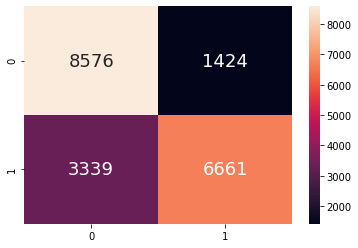

In [658]:
# Import the required metric from sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sb

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, predicted), annot = True, fmt=".0f", annot_kws={"size": 18})

The model performs reasonably well, but had a greater tendency to predict tweets as negative when they're actaully positive compared to cases where tweets were predicted as positive when they were actually negative.

But overall, the TN and TP rates were still high


X = predicted

Y = Actual

0 = negative

1 = positive

**You can use this to do some sanity checks based on the test data**

In [659]:
k  = 25
for i in range(k):
  print(test_df["tweet"][i], predicted[i], y_train[i])


Heading out to Staples to get my Admission Ticket out for the SATs tomorrow THEN get my food  0 0
really tired going to go to bed now  0 1
See No retweetsnot many followers  and I run and Ive hand copied the new testament too Interesting  0 0
has just had her hair done  just want some extensions 0 1
My face is feeling it too I look red  You have to admit it was fun 0 1
Getting ready to give Em her first driving lesson Shes going to do great If you can drive this van you can drive anything  1 0
About to make popcorn and cuddle up and watch the movie awards  1 1
theres nothing on tv and school tomorrow  SAVE MEE 0 0
watching the Dark Knight  1 1
says back in Bacolod  downloading pictures 1 0
bradie your a real man  1 0
that hurt my ears  hehe 0 0
We bought Dr Horrible on iTunes Its very good worth the price IMO But would be nice to watch it on Hulu  0 1
Missing Sexy Security Council  0 1
is going to see Thriller tonight  1 0
I miss my love sooooo much    0 0
One week  till Three days 0 0

**Remember, 0 = Negative, and 1 = Positive**

## INTERMISIONNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN

In [702]:
df = pd.read_csv("gdrive/My Drive/twitter_data.csv", encoding='latin-1', header= None) # Read the data in
df = df.drop(columns= [0, 1, 2, 3, 4])  # Drop all useless data
df.columns = ['tweet'] # Rename the relavant columns

# create new df containing negative sentiment
df_pred = df[69420:69421]

df_pred = df_pred.reset_index(drop=True)

Ask for input

In [706]:
def check_the_tweet(user_input):
  df_pred["tweet"][0] = user_input

  # these regexesr enable us to filter out unwanted data
  regex1 = re.compile('@') # format to remove @username_chungus from a string
  regex2 = re.compile('#') # format to remove #Ole'sAtTheWheel from a string
  regex3 = re.compile('http') # format to remove http/https://blahblah.com (Dont blame me if you click this link i dunno where it goes) from a string
  regex4 = re.compile('www') # format to remove www.blahblah.com from a string
  regex5 = re.compile('\d') # format to remove numbers from a string
  regex6 = re.compile(r'[^\w\s]') # format to remove punctuations from a list


  process_pred = df_pred['tweet'][0]
  process_pred = process_pred.split(" ")
    
  process_pred = [s for s in process_pred if not regex1.match(s)]
  process_pred = [s for s in process_pred if not regex2.match(s)]
  process_pred = [s for s in process_pred if not regex3.match(s)]
  process_pred = [s for s in process_pred if not regex4.match(s)]
  process_pred = [s for s in process_pred if not regex5.match(s)]
  process_pred = [s for s in process_pred if not regex6.match(s)]

    

  df_pred['tweet'][0] =  " ".join(process_pred)
  df_pred['tweet'][0] = re.sub(r'[^\w\s]', '', df_pred['tweet'][0]) # format to remove punctuations from a string

  df_pred['tweet_token'] = 'hi'

  df_pred['tweet_token'][0] = " ".join(  tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', df_pred['tweet'][0].lower().strip()))  )

  maxlen = 70

  ## add special tokens
  maxqnans = np.int(maxlen-20)  # The tokenized from would end up being too long as seen by the values of mn and np, thus we would just take the first #maxqns (70 - 20 = 50) number of tokens 
  df_pred_tokenized_list = ["[CLS] "+  " ".join(txt.split(" ")[:maxqnans]) + " [SEP]" for txt in df_pred["tweet_token"]]

  ## generate masks for pred
  masks_pred = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(txt.split(" "))) for txt in df_pred_tokenized_list]

  ## padding for pred
  txt2seq_pred = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in df_pred_tokenized_list]

  ## generate idx for pred
  idx_pred = []

  for seq in txt2seq_pred:
    the_id = tokenizer.convert_tokens_to_ids(seq.split(" ")) 
    idx_pred.append(the_id)

  ## generate segments for pred
  segments_pred = [] 
  for seq in txt2seq_pred:
    temp, i = [], 0
    for token in seq.split(" "):
      if token != "[SEP]":
        temp.append(i)
      else:
        i = 1
        temp.append(i)
    segments_pred.append(temp)


  df_pred["token_id"] = idx_pred
  df_pred["masks"] = masks_pred
  df_pred["segments"] = segments_pred

  idx_pred = [i for i in df_pred["token_id"]]
  masks_pred = [i for i in df_pred["masks"]]

  ## feature matrix
  X_pred = []
  X_pred = [np.asarray(idx_pred, dtype='int32'), 
            np.asarray(masks_pred, dtype='int32')]

  ## make the prediction
  y_pred = pred_df["emotion"].values

  ## get the predictio array
  pred_prob = model.predict(X_pred)
  pred_list = [np.argmax(pred) for pred in pred_prob]

  dict_sentiment = {0: "Negative", 1:"Positive"}

  k = 0
  print(df_pred["tweet"][k])
  print("The predicton is", dict_sentiment[pred_list[k]])

In [708]:
check_the_tweet( input("Enter the tweet you want to analyse: ") )

Enter the tweet you want to analyse: rooney id he GOAT hes amazing. a wizard
rooney id he GOAT hes amazing a wizard
The predicton is Positive
